In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
BATCH_SIZE = 64
IMAGE_SIZE = 300
train_path = "../input/dermnet/train"
test_path = "../input/dermnet/test"

In [4]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR,IMAGE_SIZE,BATCH_SIZE):
  train_datagen = ImageDataGenerator(rescale=(1./255),
                                     shear_range=0.2,
                                     zoom_range=0.3,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     brightness_range=[0.2,1.2],
                                     rotation_range=0.2,
                                     horizontal_flip=True)

  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=BATCH_SIZE,
                                                      class_mode='categorical',
                                                      target_size=(IMAGE_SIZE, IMAGE_SIZE))

  test_datagen = ImageDataGenerator(rescale=1./255)

  
  test_generator = test_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    target_size=(IMAGE_SIZE, IMAGE_SIZE))
  
  return train_generator, test_generator

In [5]:
train_generator,test_generator=train_val_generators(train_path, test_path,IMAGE_SIZE,BATCH_SIZE)

Found 15557 images belonging to 23 classes.
Found 4002 images belonging to 23 classes.


(64, 300, 300, 3)
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


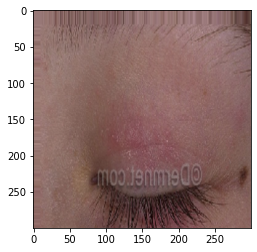

(64, 300, 300, 3)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


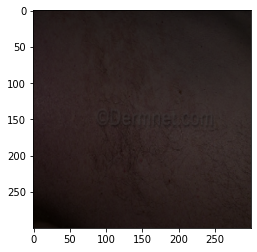

(64, 300, 300, 3)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


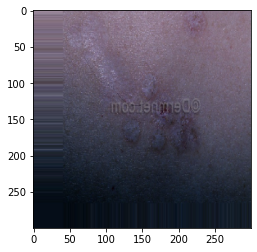

(64, 300, 300, 3)
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


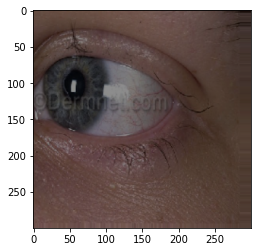

(64, 300, 300, 3)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


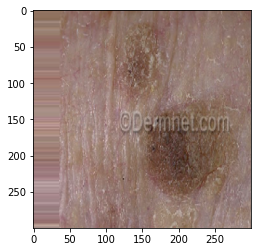

In [6]:
for _ in range(5):
    img, label = train_generator.next()
    print(img.shape)  
    print(label[0])
    plt.imshow(img[0])
    plt.show()

In [7]:
class_names = train_generator.class_indices
class_names

{'Acne and Rosacea Photos': 0,
 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions': 1,
 'Atopic Dermatitis Photos': 2,
 'Bullous Disease Photos': 3,
 'Cellulitis Impetigo and other Bacterial Infections': 4,
 'Eczema Photos': 5,
 'Exanthems and Drug Eruptions': 6,
 'Hair Loss Photos Alopecia and other Hair Diseases': 7,
 'Herpes HPV and other STDs Photos': 8,
 'Light Diseases and Disorders of Pigmentation': 9,
 'Lupus and other Connective Tissue diseases': 10,
 'Melanoma Skin Cancer Nevi and Moles': 11,
 'Nail Fungus and other Nail Disease': 12,
 'Poison Ivy Photos and other Contact Dermatitis': 13,
 'Psoriasis pictures Lichen Planus and related diseases': 14,
 'Scabies Lyme Disease and other Infestations and Bites': 15,
 'Seborrheic Keratoses and other Benign Tumors': 16,
 'Systemic Disease': 17,
 'Tinea Ringworm Candidiasis and other Fungal Infections': 18,
 'Urticaria Hives': 19,
 'Vascular Tumors': 20,
 'Vasculitis Photos': 21,
 'Warts Molluscum and other Viral Inf

In [8]:
NUMBER_OF_CLASSES = len(class_names)
print(f'number of classes : {NUMBER_OF_CLASSES}')

number of classes : 23


In [9]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3), include_top = False, weights = 'imagenet')

87924736/87910968 [==============================] - 0s 0us/step


In [10]:
for layer in base_model.layers:
    layer.trainable = True

In [11]:
def output_of_last_layer(pre_trained_model, limit_layer):
  last_desired_layer = pre_trained_model.get_layer(limit_layer)
  print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)

  return last_output

In [12]:
last_output = output_of_last_layer(base_model,'mixed5')

last layer output shape:  (None, 17, 17, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 17, 17, 768), dtype=tf.float32, name=None), name='mixed5/concat:0', description="created by layer 'mixed5'")


In [13]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(NUMBER_OF_CLASSES, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(
    optimizer = Adam(learning_rate=0.0001), 
    loss = 'categorical_crossentropy', 
    metrics = ['accuracy']
)

In [14]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
custom_early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=110, 
    min_delta=0.001, 
    mode='min'
)

In [15]:
# Train the model with early stopping
history = model.fit(
    train_generator, 
    validation_data=test_generator, 
    epochs=45, 
    callbacks=[custom_early_stopping]
)


# Save the model to the working directory
model.save('/kaggle/working/my_model.pkl')

Epoch 1/45
244/244 [==============================] - 557s 2s/step - loss: 23.8572 - accuracy: 0.2191 - val_loss: 18.3438 - val_accuracy: 0.2899
Epoch 2/45
244/244 [==============================] - 465s 2s/step - loss: 14.9263 - accuracy: 0.3149 - val_loss: 12.5716 - val_accuracy: 0.3273
Epoch 3/45
244/244 [==============================] - 461s 2s/step - loss: 10.6247 - accuracy: 0.3568 - val_loss: 9.9815 - val_accuracy: 0.2959
Epoch 4/45
244/244 [==============================] - 461s 2s/step - loss: 8.4741 - accuracy: 0.3931 - val_loss: 7.5753 - val_accuracy: 0.4328
Epoch 5/45
244/244 [==============================] - 469s 2s/step - loss: 6.9869 - accuracy: 0.4302 - val_loss: 7.0049 - val_accuracy: 0.4023
Epoch 6/45
244/244 [==============================] - 469s 2s/step - loss: 6.2298 - accuracy: 0.4556 - val_loss: 6.6618 - val_accuracy: 0.3303
Epoch 7/45
244/244 [==============================] - 468s 2s/step - loss: 6.0076 - accuracy: 0.4613 - val_loss: 5.6997 - val_accuracy: 0

In [16]:
# Save the model to the working directory
model.save('/kaggle/working/my_model.pkl')

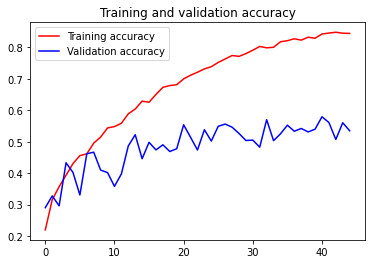

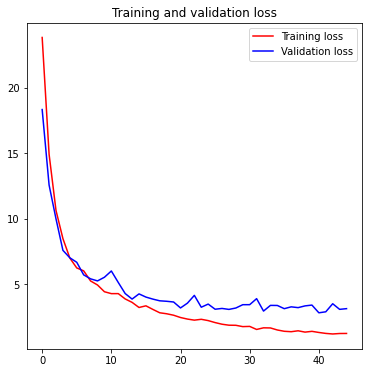

<Figure size 432x432 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure(figsize=(6,6))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure(figsize=(6,6))


plt.show()

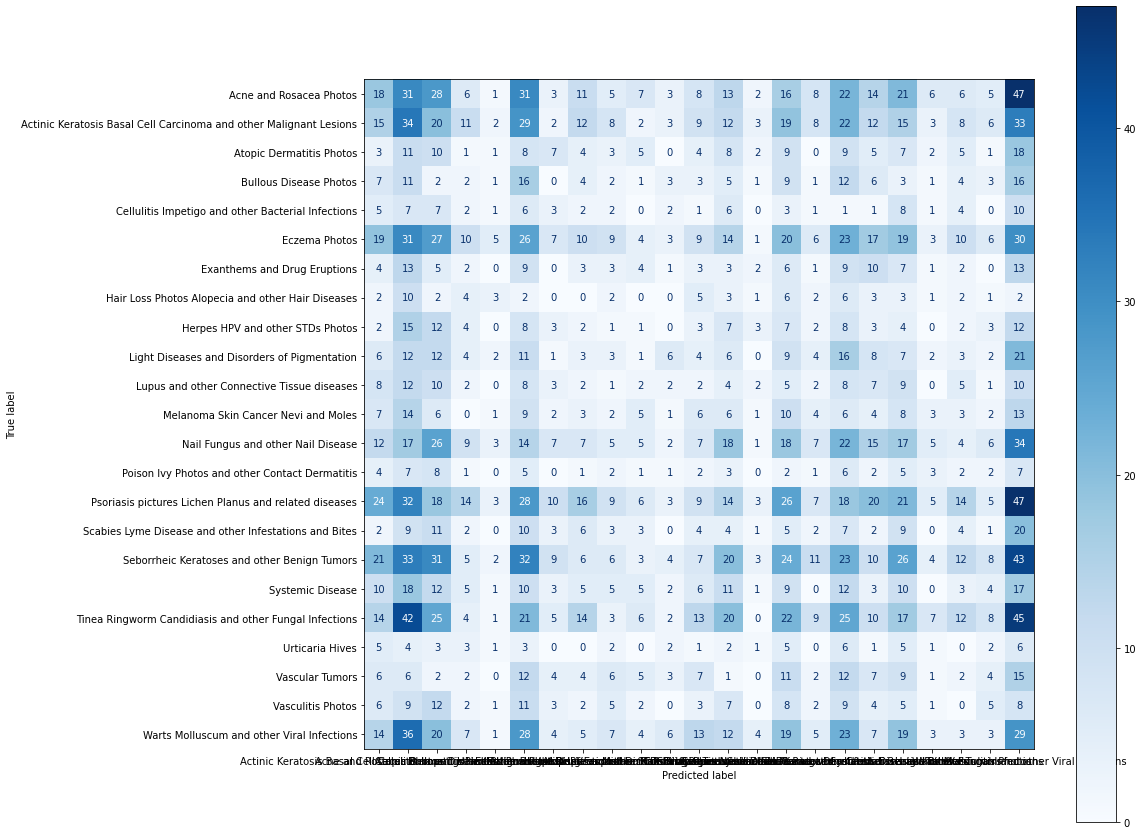

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import numpy as np

test_true=test_generator.classes
test_pred_raw = model.predict(test_generator)
test_pred = np.argmax(test_pred_raw, axis=1)

cm = confusion_matrix(test_true, test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,cmap=plt.cm.Blues)
plt.show()

In [19]:
# !mkdir -p saved_model
model.save('my_model') 

In [20]:
import os
import shutil

# Path to the working directory
working_dir = '/kaggle/working/'

# Iterate over all files and directories in the working directory
for filename in os.listdir(working_dir):
    file_path = os.path.join(working_dir, filename)
    
    # Check if it's a file or directory, and remove accordingly
    if os.path.isfile(file_path) or os.path.islink(file_path):
        os.remove(file_path)  # remove the file
    elif os.path.isdir(file_path):
        shutil.rmtree(file_path)  # remove the directory


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set constants
BATCH_SIZE = 64
IMAGE_SIZE = 300
train_path = "../input/dermnet/train"
test_path = "../input/dermnet/test"
NUMBER_OF_CLASSES = len(class_names)  # Define the number of classes here

# Create the MirroredStrategy instance for using multiple GPUs
strategy = tf.distribute.MirroredStrategy()

def train_val_generators(TRAINING_DIR, VALIDATION_DIR, IMAGE_SIZE, BATCH_SIZE):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.3,
        width_shift_range=0.2,
        height_shift_range=0.2,
        brightness_range=[0.2, 1.2],
        rotation_range=0.2,
        horizontal_flip=True
    )
    
    train_generator = train_datagen.flow_from_directory(
        directory=TRAINING_DIR,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        target_size=(IMAGE_SIZE, IMAGE_SIZE)
    )

    test_datagen = ImageDataGenerator(rescale=1./255)
    
    test_generator = test_datagen.flow_from_directory(
        directory=VALIDATION_DIR,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        target_size=(IMAGE_SIZE, IMAGE_SIZE)
    )
  
    return train_generator, test_generator

# Initialize the data generators
train_generator, test_generator = train_val_generators(train_path, test_path, IMAGE_SIZE, BATCH_SIZE)
class_names = train_generator.class_indices

# Define the model within the strategy scope
with strategy.scope():
    base_model = tf.keras.applications.InceptionV3(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

    for layer in base_model.layers:
        layer.trainable = True

    def output_of_last_layer(pre_trained_model, limit_layer):
        last_desired_layer = pre_trained_model.get_layer(limit_layer)
        print('last layer output shape: ', last_desired_layer.output_shape)
        last_output = last_desired_layer.output
        print('last layer output: ', last_output)
        return last_output

    last_output = output_of_last_layer(base_model, 'mixed5')

    x = tf.keras.layers.Flatten()(last_output)
    x = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(NUMBER_OF_CLASSES, activation='softmax')(x)

    model = tf.keras.models.Model(base_model.input, x)

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

# Check if the model summary shows usage of multiple GPUs
model.summary()

# Train the model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=45,
    callbacks=[custom_early_stopping]
)


Found 15557 images belonging to 23 classes.
Found 4002 images belonging to 23 classes.
last layer output shape:  (None, 17, 17, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 17, 17, 768), dtype=tf.float32, name=None), name='mixed5/concat:0', description="created by layer 'mixed5'")
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_96 (BatchNo (None, 149, 149, 32) 96          conv2d_94[0][0] 

In [ ]:
# Save the model to the working directory
model.save('/kaggle/working/my_model') 